![Churn_fish](Project_8.jpg)

# Telecom task, Dmitriy Lyalin, summer 2023

### Service Description

The operator offers two main types of services:

1. Landline telephone communication. It's possible to connect a telephone device to multiple lines simultaneously.
2. Internet. The connection can be of two types: through a phone line (DSL - digital subscriber line) or fiber optic cable (Fiber optic).

Additionally, the following services are available:

- Internet security: antivirus (DeviceProtection) and blocking of unsafe websites (OnlineSecurity);
- Dedicated technical support line (TechSupport);
- Cloud file storage for data backup (OnlineBackup);
- Streaming television (StreamingTV) and a movie catalog (StreamingMovies).

Customers can pay for the services each month or enter into a contract for 1-2 years. Various payment methods are available, including the option to receive an electronic receipt.

### Data Description

The data consists of files obtained from different sources:

- `contract_new.csv` — contract information;
- `personal_new.csv` — customer's personal data;
- `internet_new.csv` — information about internet services;
- `phone_new.csv` — information about phone services.

In all files, the column `customerID` contains the customer's code.
The contract information is up to date as of February 1, 2020.

## Libraries and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_curve

from catboost import CatBoostClassifier
import re

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
import shap

In [3]:
contract = pd.read_csv('contract_new.csv')
personal = pd.read_csv('personal_new.csv')
internet = pd.read_csv('internet_new.csv')
phone = pd.read_csv('phone_new.csv')

In [4]:
def data_info(data):
    '''
    The function takes a dataset as input and displays key information
    about it: head, shape, missing values, and duplicates.
    '''
    display(data.head(3))
    display('data_shape', data.shape)
    data.info()
    display('data_isna_sum', data.isna().sum())
    display('duplicated_data', data.duplicated().sum())
    display('data_describe', data.describe())

In [5]:
data_info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


'data_shape'

(7043, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


'data_isna_sum'

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

'duplicated_data'

0

'data_describe'

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Dataset "contract":
- 7043 rows and 8 columns
- MonthlyCharges is a float, while TotalCharges is a string (object)
- There are no missing values or duplicates
- A significant portion of subscribers pay a small monthly amount
- The EndDate can be set to 01.02.2020 (current date)

In [6]:
data_info(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


'data_shape'

(7043, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


'data_isna_sum'

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

'duplicated_data'

0

'data_describe'

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Dataset "personal":
- 7043 rows and 5 columns
- SeniorCitizen is an integer, while the rest are strings (objects)
- There are no missing values or duplicates
- There are 6 times more young people than senior citizens

In [7]:
data_info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


'data_shape'

(5517, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


'data_isna_sum'

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

'duplicated_data'

0

'data_describe'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Dataset "internet":
- 5517 rows and 8 columns
- All columns are of object type
- There are no missing values or duplicates
- In columns other than customerID, all values are binary (Yes/No)

In [8]:
data_info(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


'data_shape'

(6361, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


'data_isna_sum'

customerID       0
MultipleLines    0
dtype: int64

'duplicated_data'

0

'data_describe'

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Dataset "phone":
- 6361 rows and 2 columns
- All columns are of object type
- There are no missing values or duplicates
- In the MultipleLines column, all values are binary (Yes/No)

In [9]:
def data_value_counts(data):
    '''
    The function takes a dataset as input and displays
    sorted value counts for each column.
    '''
    for column in data.columns:
        display(column, data[column].value_counts().sort_values(ascending=False))

In [10]:
data_value_counts(contract)

'customerID'

7590-VHVEG    1
0280-XJGEX    1
7795-CFOCW    1
9237-HQITU    1
9305-CDSKC    1
             ..
2234-XADUH    1
4801-JZAZL    1
8361-LTMKD    1
1122-JWTJW    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

'BeginDate'

2014-02-01    366
2019-09-01    237
2019-10-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

'EndDate'

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64

'Type'

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

'PaperlessBilling'

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

'PaymentMethod'

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

'MonthlyCharges'

20.05    61
19.85    45
19.95    44
19.90    44
20.00    43
         ..
82.40     1
56.00     1
26.50     1
40.90     1
78.70     1
Name: MonthlyCharges, Length: 1585, dtype: int64

'TotalCharges'

           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
923.4       1
3034.57     1
2669.63     1
1844.26     1
7251.82     1
Name: TotalCharges, Length: 6658, dtype: int64

- Out of 7043 customers, 5942 have an active contract.

In [11]:
data_value_counts(personal)

'customerID'

7590-VHVEG    1
0280-XJGEX    1
7795-CFOCW    1
9237-HQITU    1
9305-CDSKC    1
             ..
2234-XADUH    1
4801-JZAZL    1
8361-LTMKD    1
1122-JWTJW    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

'gender'

Male      3555
Female    3488
Name: gender, dtype: int64

'SeniorCitizen'

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

'Partner'

No     3641
Yes    3402
Name: Partner, dtype: int64

'Dependents'

No     4933
Yes    2110
Name: Dependents, dtype: int64

- The number of female and male customers is approximately equal.
- The number of customers with partners and without partners is also approximately equal.
- Out of 7000 subscribers, around 2000 have dependents, while 5000 do not have dependents.

In [12]:
data_value_counts(internet)

'customerID'

7590-VHVEG    1
9763-GRSKD    1
7795-CFOCW    1
9237-HQITU    1
9305-CDSKC    1
             ..
2234-XADUH    1
4801-JZAZL    1
8361-LTMKD    1
7203-OYKCT    1
3186-AJIEK    1
Name: customerID, Length: 5517, dtype: int64

'InternetService'

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

'OnlineSecurity'

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

'OnlineBackup'

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

'DeviceProtection'

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

'TechSupport'

No     3473
Yes    2044
Name: TechSupport, dtype: int64

'StreamingTV'

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

'StreamingMovies'

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

In [13]:
data_value_counts(phone)

'customerID'

5575-GNVDE    1
5248-YGIJN    1
9305-CDSKC    1
1452-KIOVK    1
7892-POOKP    1
             ..
6840-RESVB    1
2234-XADUH    1
8361-LTMKD    1
4807-IZYOZ    1
3186-AJIEK    1
Name: customerID, Length: 6361, dtype: int64

'MultipleLines'

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

- Just slightly over half of the subscribers have MultipleLines.

## Work Plan

1. Carefully merge the dataframes (exploration of the unified dataframe).
2. Data preprocessing (handling anomalies, creating new features, etc.), identify the target variable.
3. Split the dataset into train and test sets (0.25).
4. Create a pipeline for One-Hot Encoding (considering the used models) and scaling.
5. Train 3 models: decision tree, random forest, boosting. Select the best one.
6. Evaluate the performance of the best model on the test set.
7. Investigate feature importance of the best model.

## Data Processing

In [14]:
contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


In [15]:
contract.columns, personal.columns, internet.columns, phone.columns

(Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
        'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
       dtype='object'),
 Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object'),
 Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
       dtype='object'),
 Index(['customerID', 'MultipleLines'], dtype='object'))

In [16]:
def rename_columns(df):
    '''
    The function takes a dataset as input and renames
    the column names to follow the snake_case convention.
    '''
    for column in df.columns:
        new_column_name = re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower()
        df.rename(columns={column: new_column_name}, inplace=True)
    df.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)
    df.rename(columns={'streaming_t_v': 'streaming_tv'}, inplace=True)
    display(df.head(1))

In [17]:
rename_columns(contract)
rename_columns(personal)
rename_columns(internet)
rename_columns(phone)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No


,customer_id,multiple_lines
0,5575-GNVDE,No


Let's check whether all subscribers are unique or if there are those who left and then returned.

In [18]:
contract.customer_id.value_counts().sort_values(ascending=False)

7590-VHVEG    1
0280-XJGEX    1
7795-CFOCW    1
9237-HQITU    1
9305-CDSKC    1
             ..
2234-XADUH    1
4801-JZAZL    1
8361-LTMKD    1
1122-JWTJW    1
3186-AJIEK    1
Name: customer_id, Length: 7043, dtype: int64

In [19]:
len(contract)

7043

In [20]:
contract.customer_id.nunique()

7043

All customer IDs are unique. Quite surprising, isn't it?

Now, let's check if all customer IDs from the "personal," "internet," and "phone" datasets are included in the "contract" dataset:

In [21]:
def check_unique_values(series_1, series_2):
    '''
    The function takes two Pandas series as input and outputs
    whether all unique values of one series are present in the other series.
    '''
    unique_values_series_1 = series_1.unique()
    unique_values_series_2 = series_2.unique()
    
    return all(np.isin(unique_values_series_2, unique_values_series_1))

In [22]:
(
check_unique_values(contract.customer_id, personal.customer_id),
check_unique_values(contract.customer_id, internet.customer_id),
check_unique_values(contract.customer_id, phone.customer_id)
)

(True, True, True)

Just to be thorough, let's check once again:

In [23]:
def get_unique_differences(series_1, series_2):
    '''
    The function takes two Pandas series as input and outputs a list
    of values that are present in the first series but not in the second series.
    '''
    unique_values_series_1 = set(series_1.unique())
    unique_values_series_2 = set(series_2.unique())   
    differences = list(unique_values_series_1 - unique_values_series_2)

    return differences

In [24]:
get_unique_differences(contract.customer_id, personal.customer_id)

[]

In [25]:
get_unique_differences(internet.customer_id, contract.customer_id)

[]

In [26]:
get_unique_differences(phone.customer_id, contract.customer_id)

[]

That's very interesting! All customer ID values from the "personal," "internet," and "phone" datasets are present in the "contract" dataset.  
Additionally, there are no duplicate customer IDs; all values are unique. This implies that you can seamlessly join the "personal," "internet," and "phone" datasets to the "contract" dataset without any issues.

In [27]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Let's add the target variable: whether a subscriber has churned (1) or not (0).

In [28]:
contract['target'] = 1
contract.loc[contract['end_date'] == 'No', 'target'] = 0

In [29]:
contract.head(2)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0


In [30]:
contract.target.value_counts()

0    5942
1    1101
Name: target, dtype: int64

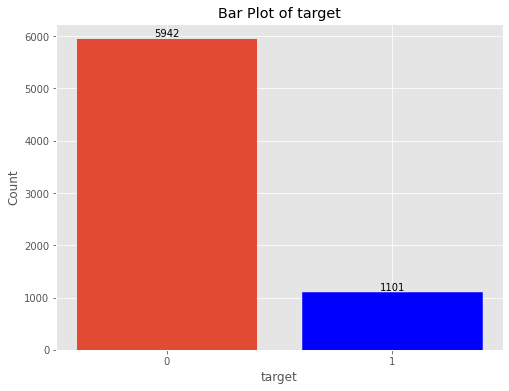

In [31]:
target_column = 'target'
value_counts = contract[target_column].value_counts()
plt.figure(figsize=(8, 6))

bars = plt.bar(value_counts.index, value_counts.values)
plt.xlabel(target_column)
plt.ylabel('Count')
plt.xticks([0, 1])  # Set x-axis ticks to only 0 and 1
plt.title(f'Bar Plot of {target_column}')
bars[1].set_color('blue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, round(yval), ha='center', va='bottom')

plt.show()

Alright. Now we can see 1101 churned customers.

In [32]:
personal.head(2)

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


In [33]:
internet.head(2)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


In [34]:
phone.head(2)

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No


Now, let's merge all the datasets into one, as we discussed earlier.

In [35]:
data = contract.merge(personal, how='left', on='customer_id')

In [36]:
data.shape

(7043, 13)

In [37]:
data = data.merge(internet, how='left', on='customer_id')
data.shape

(7043, 20)

In [38]:
data = data.merge(phone, how='left', on='customer_id')
data.shape

(7043, 21)

In [39]:
data.head(2)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   target             7043 non-null   int64  
 9   gender             7043 non-null   object 
 10  senior_citizen     7043 non-null   int64  
 11  partner            7043 non-null   object 
 12  dependents         7043 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

In [41]:
data.isnull().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
target                  0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [42]:
data['end_date'] = data['end_date'].replace('No', '2020-02-01')

In [43]:
data.end_date.value_counts()

2020-02-01    5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: end_date, Length: 67, dtype: int64

Now, let's fill all the missing values in the "internet" and "phone" datasets with 'unknown'.

In [44]:
data = data.fillna('unknown')
data.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,unknown
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   target             7043 non-null   int64  
 9   gender             7043 non-null   object 
 10  senior_citizen     7043 non-null   int64  
 11  partner            7043 non-null   object 
 12  dependents         7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protection  7043 

Now, let's take a look at the "TotalCharges" column and understand why it's of type object.

In [46]:
data.total_charges.value_counts()

           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     1
Name: total_charges, Length: 6658, dtype: int64

In [47]:
data[data.total_charges == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,unknown
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,Male,...,No,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,Male,...,Yes,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Yes
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,unknown
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,Male,...,Yes,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,Male,...,Yes,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Yes
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,Female,...,Yes,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,Male,...,Yes,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,Female,...,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Understood. These are subscribers who joined on the same day the contract data was extracted, which is 2020-02-01, and they haven't made any payments yet. So, let's replace the spaces with zero.

In [48]:
data['total_charges'] = data['total_charges'].replace(' ', '0')
data['total_charges'] = data['total_charges'].astype('float')

In [49]:
data.total_charges.value_counts()

0.00       11
20.45       6
101.00      5
21.53       4
40.10       4
           ..
4357.50     1
3509.55     1
2530.80     1
2599.10     1
7251.82     1
Name: total_charges, Length: 6658, dtype: int64

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   target             7043 non-null   int64  
 9   gender             7043 non-null   object 
 10  senior_citizen     7043 non-null   int64  
 11  partner            7043 non-null   object 
 12  dependents         7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protection  7043 

In [51]:
data.head(2)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,unknown
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No


And finally, let's add a new feature - "customer lifetime." Also, we will remove the "begin_date" and "end_date" columns, as they could lead to data leakage during training.

In [52]:
data.end_date = data.end_date.astype('datetime64')
data.begin_date = data.begin_date.astype('datetime64')

In [53]:
data['abonents_days'] = data.end_date - data.begin_date

In [54]:
data.head(2)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,abonents_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,No,DSL,No,Yes,No,No,No,No,unknown,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,1036 days


In [55]:
data['abonents_days'] = data['abonents_days'].dt.days

In [56]:
data = data.drop(['begin_date', 'end_date'], axis=1)

In [57]:
data.head(2)

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,abonents_days
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,unknown,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036


In [58]:
data.senior_citizen = data.senior_citizen.astype('object')

Excellent! The training dataset is ready!

## Exploratory Data Analysis (EDA)

In [59]:
data.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,abonents_days
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,unknown,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,unknown,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,153


Let's start examining the target column based on each feature:

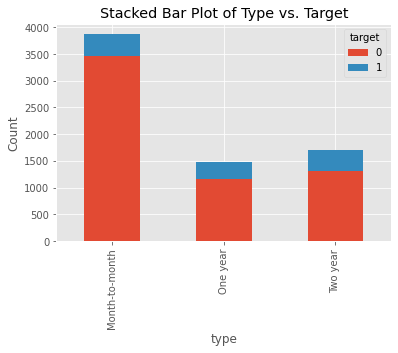

In [60]:
type_column = 'type'
target_column = 'target'

# Group the data by 'type' and 'target', then count occurrences
grouped_counts = data.groupby([type_column, target_column]).size().unstack()

# Create a stacked bar plot
ax = grouped_counts.plot(kind='bar', stacked=True)
ax.set_xlabel(type_column)
ax.set_ylabel('Count')
ax.set_title('Stacked Bar Plot of Type vs. Target')
plt.show()

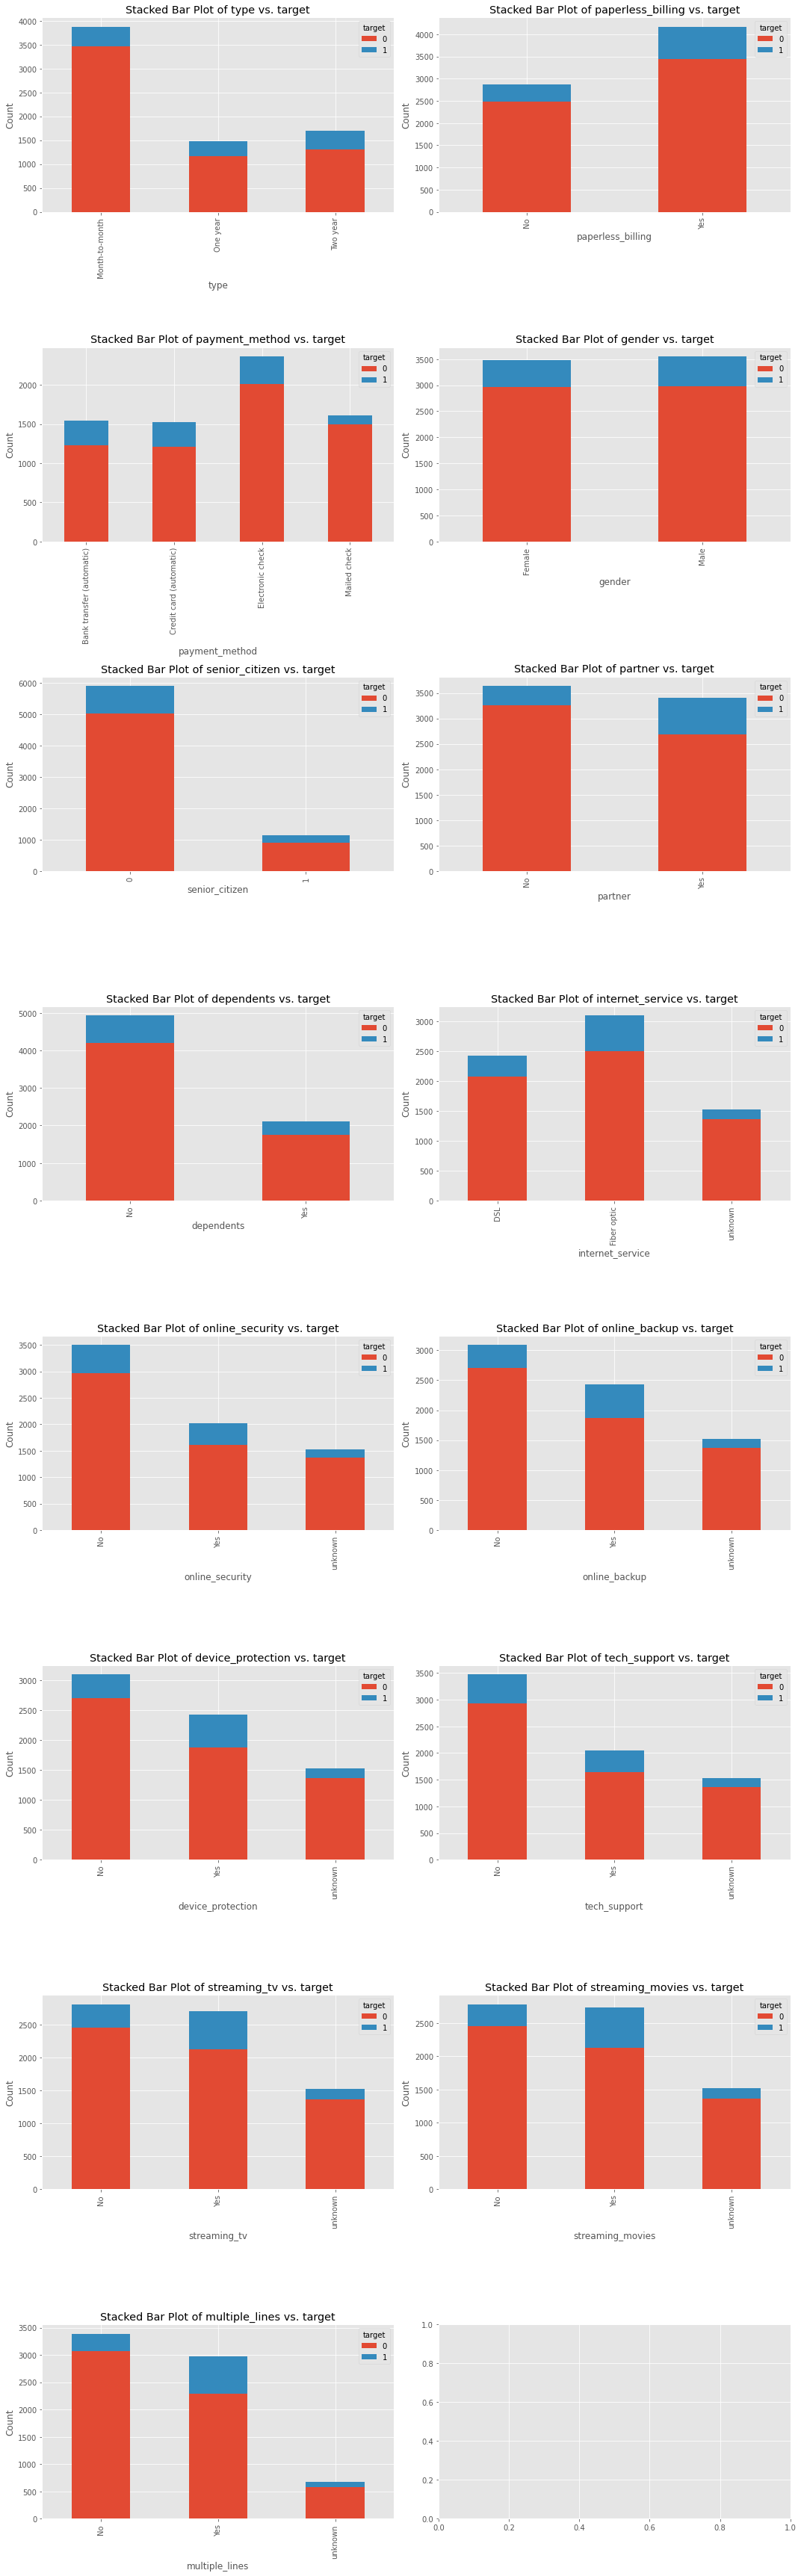

In [61]:
columns_to_plot = [
    'type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
    'partner', 'dependents', 'internet_service', 'online_security',
    'online_backup', 'device_protection', 'tech_support',
    'streaming_tv', 'streaming_movies', 'multiple_lines'
]

num_rows = (len(columns_to_plot) + 1) // 2
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 6 * num_rows))

for i, column in enumerate(columns_to_plot):
    target_column = 'target'    
    grouped_counts = data.groupby([column, target_column]).size().unstack()
    row = i // 2
    col = i % 2
    
    ax = grouped_counts.plot(kind='bar', stacked=True, ax=axes[row, col])
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(f'Stacked Bar Plot of {column} vs. {target_column}')

plt.tight_layout()
plt.show()

Let's examine the results:
1. 'type' - it appears that the count of churned abonents is the same, but the percentage is higher with a 2-year contract.
2. 'paperless_billing' - definitely, people with 'paperless billing' tend to leave the company more.
3. 'payment_method' -  "mailed check" is the "best defense" against churn.
4. 'gender' - males tend to leave the company slightly more often.
5. 'senior_citizen' - senior citizens doesnt like operator changes
6. 'partner' - senior citizens dislike changes of operator, its good news.
7. 'dependents' - the percantage is about the same.
8. 'internet_service' - its strange but people who have fiber optic leave the company more often.
9. 'online_security' and 'tech_support' seem to be highly correlated. Let's check it later.

    Now, onto more services. It appears that if you want to encourage a subscriber to churn, you should activate online security, online backup, device protection, streaming TV, streaming movies, and multiple lines for them. Either these services are costly, or people are not satisfied with their quality.

In [62]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(data['online_security'], data['tech_support'])

# Calculate the Chi-squared statistic and p-value
chi2, p, _, _ = chi2_contingency(contingency_table)

# Calculate Cramér's V
n = contingency_table.sum().sum()
cramers_v = (chi2 / n)**0.5

print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")
print(f"Cramér's V: {cramers_v}")

Chi-squared: 7569.722976675825
P-value: 0.0
Cramér's V: 1.036719217191437


Cramér's V ranges from 0 to 1: 0 means no association, while 1 signifies a perfect association. Here, a value around 1.04 indicates a strong and nearly perfect association between 'online_security' and 'tech_support'. So, we could delete 1 of these 2 columns.

In [63]:
num_columns_to_plot = ['monthly_charges', 'total_charges', 'abonents_days']

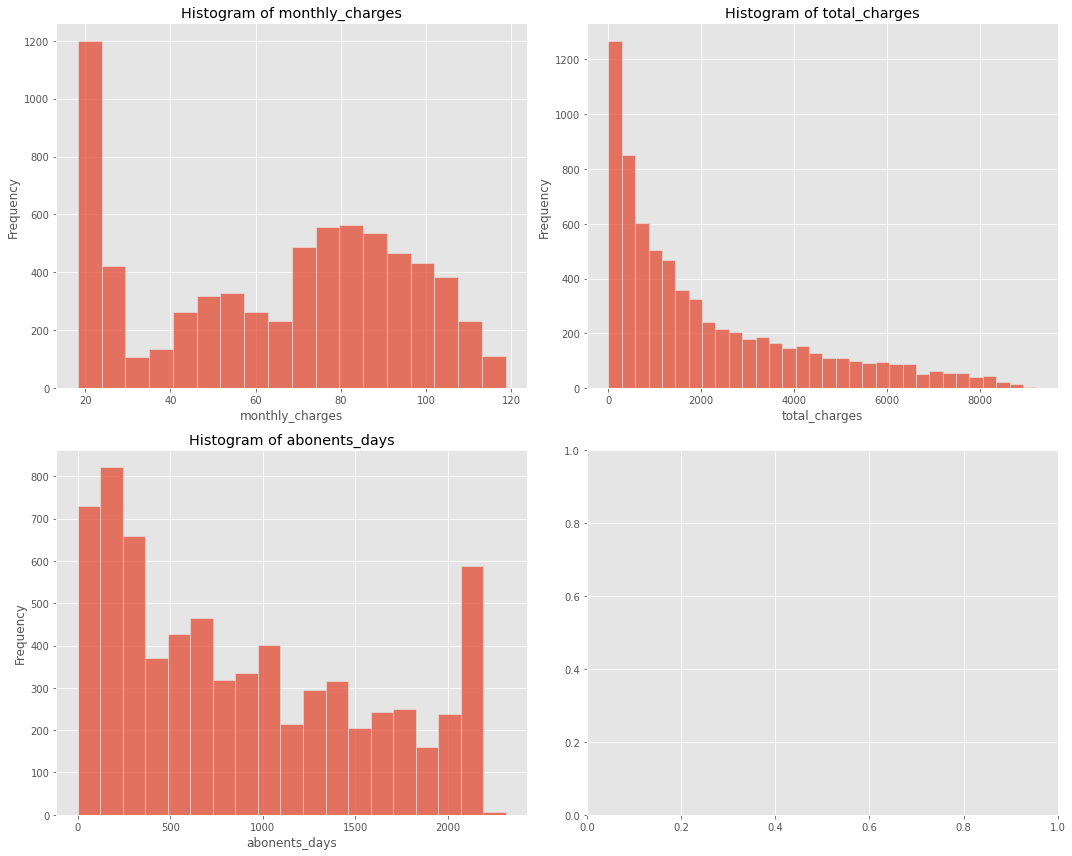

In [64]:
num_rows = (len(num_columns_to_plot) + 1) // 2

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 6 * num_rows))

for i, column in enumerate(num_columns_to_plot):
    row = i // 2
    col = i % 2
    
    ax = sns.histplot(data[column], bins='auto', ax=axes[row, col])
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')
    
plt.tight_layout()
plt.show()

Lets do the same thing with numerical columns:

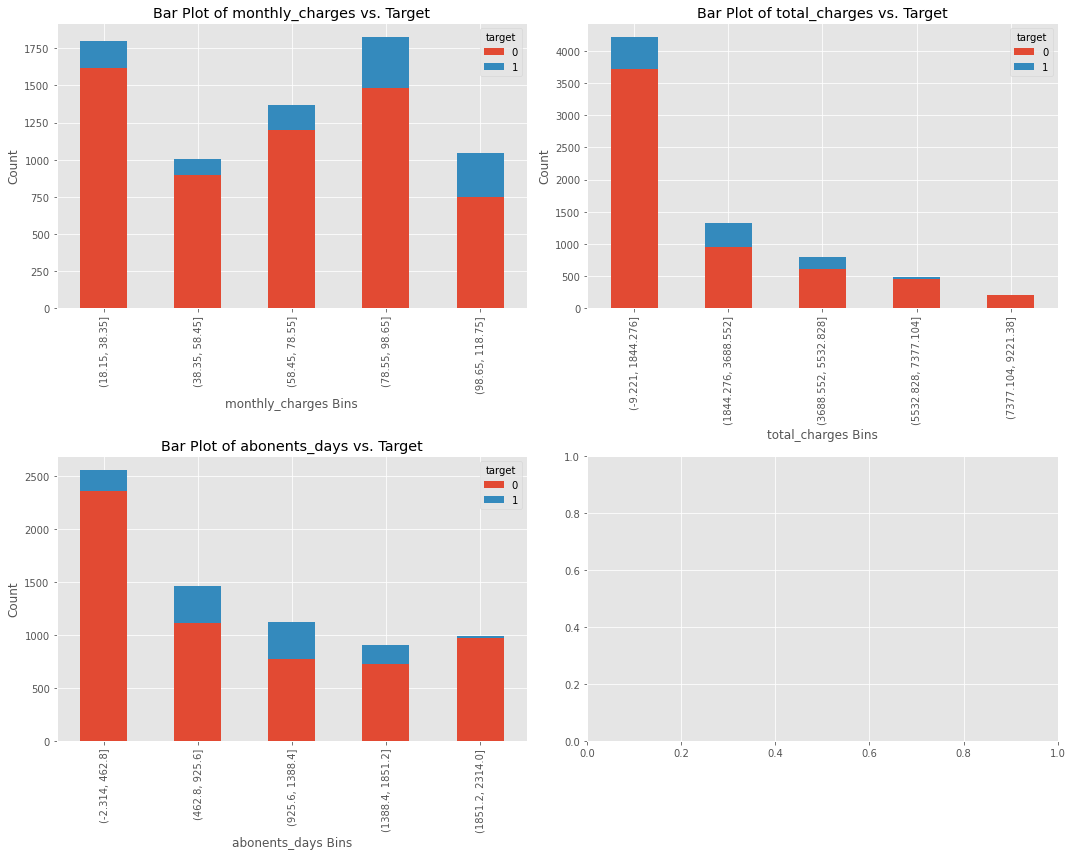

In [65]:
num_bins = 5
num_rows = (len(num_columns_to_plot) + 1) // 2
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 6 * num_rows))

for i, column in enumerate(num_columns_to_plot):
    row = i // 2
    col = i % 2
    
    # Create bins for the current numerical column
    bins = pd.cut(data[column], bins=num_bins)
    
    # Group the data by bins and 'target', then count occurrences
    grouped_counts = data.groupby([bins, 'target']).size().unstack()
    
    # Calculate the current subplot's row and column index
    row = i // 2
    col = i % 2
    
    # Create a bar plot in the current subplot
    ax = grouped_counts.plot(kind='bar', stacked=True, ax=axes[row, col])
    ax.set_xlabel(f'{column} Bins')
    ax.set_ylabel('Count')
    ax.set_title(f'Bar Plot of {column} vs. Target')
    
# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

1. 'monthly_charges' - we can observe an increase in the percentage of churned subscribers from the 2nd bin (38-58) to the last bin (98-118). This is somewhat unexpected. I had assumed that the higher the amount an subscriber pays, the more time the support team should invest to ensure the satisfaction of these clients.
2. 'total_charges' - interestingly, the lowest churn rate is observed from the 4th bin (total charge of 5000).
3. 'abonents_days' - with this new feature, we can observe the lowest churn rate from the 3rd to the 5th bin (from 900 to 1800 days). Therefore, we can definitively say that the oldest abonents are the most loyal!

## Features preprocessing, pipeline, models

Let's set the desired random_state.

In [66]:
RANDOM_STATE = 60623

Let's write pipelines for Decision Tree and Random Forest models using StandardScaler and OneHotEncoder.

Let's start by splitting into features and target:

In [67]:
features = data.drop(['target', 'customer_id', 'tech_support'], axis=1)
target = data['target']
features.shape, target.shape

((7043, 17), (7043,))

We will split the features and target into training and testing sets:

In [68]:
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((5282, 17), (1761, 17), (5282,), (1761,))

In [69]:
numeric_columns = features_train.select_dtypes(exclude='object').columns.to_list()
numeric_columns

['monthly_charges', 'total_charges', 'abonents_days']

In [70]:
object_columns = features_train.select_dtypes(include='object').columns.to_list()
object_columns

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [71]:
numeric_transformer = StandardScaler()
object_transformer = OneHotEncoder()

In [72]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_columns),
        ('object', object_transformer, object_columns)
    ], remainder = 'passthrough')

Lets code all pipelines for our models:

In [73]:
pipeline_logist = Pipeline([
    ('preprocessor', preprocessor),
    ('model_logist', LogisticRegression(random_state=RANDOM_STATE))
])

In [74]:
pipeline_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('model_tree', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [75]:
pipeline_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('model_forest', RandomForestClassifier(random_state=RANDOM_STATE))
])

Now, let's create a pipeline for CatBoost using only StandardScaler, as CatBoost handles categorical features encoding internally.

In [76]:
preprocessor_cat = ColumnTransformer(
    [('num', StandardScaler(), numeric_columns)],
    remainder='passthrough')

preprocessor_cat.fit(features_train)

display(features_train.head(3))
display(pd.DataFrame(preprocessor_cat.transform(features_train)).head(3))

cat_columns = range(len(numeric_columns), len(features_train.columns))

print(f'''We verify that the numbers correspond to the categorical features from the table above: {list(cat_columns)}''')

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,streaming_tv,streaming_movies,multiple_lines,abonents_days
4920,Two year,No,Bank transfer (automatic),20.10,1427.10,Female,0,Yes,Yes,unknown,unknown,unknown,unknown,unknown,unknown,No,2163
6226,Two year,No,Mailed check,25.75,1339.00,Male,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,Yes,1583
4099,Month-to-month,No,Bank transfer (automatic),29.45,189.07,Female,0,No,No,DSL,Yes,No,No,No,No,unknown,184


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.46955,-0.319692,1.853234,Two year,No,Bank transfer (automatic),Female,0,Yes,Yes,unknown,unknown,unknown,unknown,unknown,unknown,No
1,-1.281736,-0.361758,1.003231,Two year,No,Mailed check,Male,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,Yes
2,-1.158743,-0.910837,-1.047034,Month-to-month,No,Bank transfer (automatic),Female,0,No,No,DSL,Yes,No,No,No,No,unknown


We verify that the numbers correspond to the categorical features from the table above: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [77]:
pipeline_cat = Pipeline([
    ('preprocessor_cat', preprocessor_cat),
    ('model_cat', CatBoostClassifier(random_state=RANDOM_STATE,
                                     verbose=False,
                                     cat_features=list(cat_columns)))
])

## Model Training using GridSearchCV and cross_val_score

### Logistic regression

In [78]:
param_grid_logist = {'model_logist__C': [0.01, 0.1, 1, 10, 100]}

In [79]:
grid_search_logist = GridSearchCV(pipeline_logist, param_grid_logist, scoring='roc_auc', cv=5)

In [80]:
grid_search_logist.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'abonents_days']),
                                                                        ('object',
                                                                         OneHotEncoder(),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('model_logist',
                                        LogisticRegression(random_state=60623))]),
             param_grid={'model_logist__C': [0.01, 0.1, 1, 10, 100]},
             scoring='roc_auc')

In [81]:
best_params_logist = grid_search_logist.best_params_
best_score_logist = grid_search_logist.best_score_
best_params_logist, best_score_logist

({'model_logist__C': 0.1}, 0.7606695693244995)

Roc auc 0.76. Not bad as a baseline. Lets try to improve it.

### Desicion tree

In [82]:
param_grid_tree = {'model_tree__max_depth': [i for i in range(1,15)]}

In [83]:
grid_search_tree = GridSearchCV(pipeline_tree, param_grid_tree, scoring='roc_auc', cv=5)

In [84]:
grid_search_tree.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'abonents_days']),
                                                                        ('object',
                                                                         OneHotEncoder(),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('model_tree',
                                        DecisionTreeClassifier(random_state=60623))]),
             param_grid={'model_tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14]},
             scoring='roc_auc')

In [85]:
best_params_tree = grid_search_tree.best_params_
best_score_tree = grid_search_tree.best_score_
best_params_tree, best_score_tree

({'model_tree__max_depth': 5}, 0.7910418346807212)

Roc auc 0.79. A bit better.

Now lets visualize best tree:

In [86]:
encoder = OrdinalEncoder()
encoded_features_train = features_train.copy()
encoded_features_train[object_columns] = encoder.fit_transform(encoded_features_train[object_columns])

In [87]:
tree_classifier = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)
tree_classifier.fit(encoded_features_train, target_train)

DecisionTreeClassifier(max_depth=5, random_state=60623)

In [88]:
y_pred_proba = tree_classifier.predict_proba(encoded_features_train)[:, 1]
roc_auc = roc_auc_score(target_train, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.8286


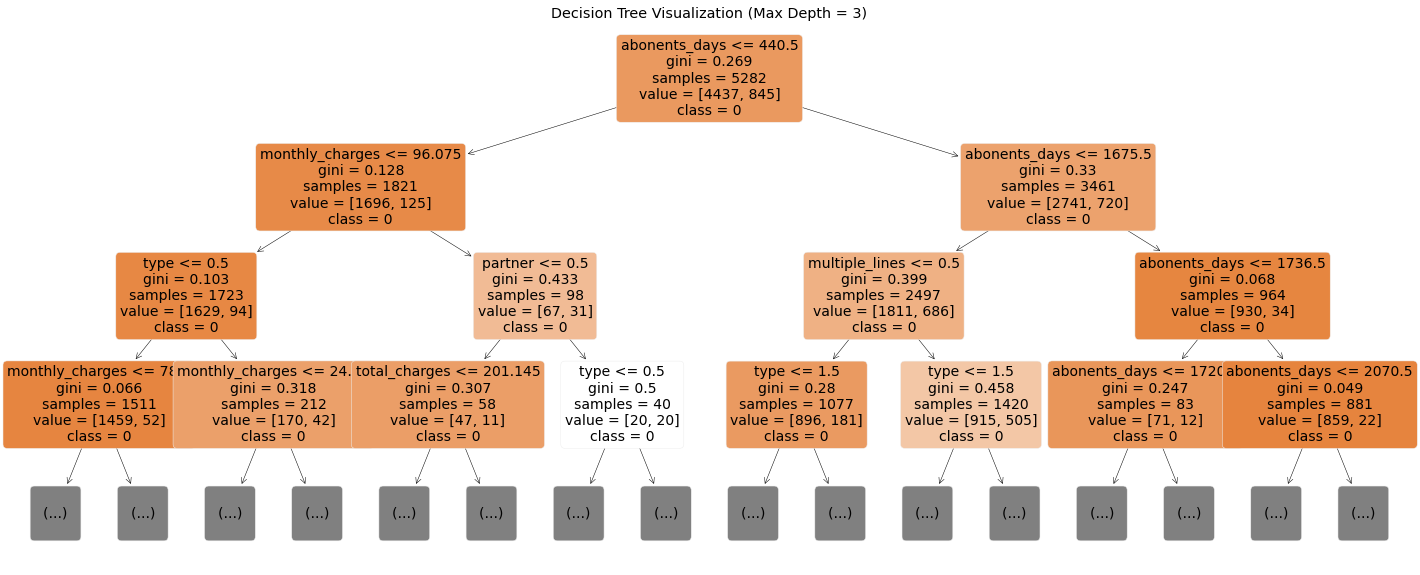

In [89]:
plt.figure(figsize=(25, 10))
plot_tree(tree_classifier,
          feature_names=encoded_features_train.columns,
          class_names=[str(label) for label in tree_classifier.classes_],
          filled=True,
          rounded=True,
          fontsize=14,
          max_depth=3)  # Set max_depth to 3
plt.title("Decision Tree Visualization (Max Depth = 3)")
plt.show()

### Random forest

In [90]:
param_grid_forest = {'model_forest__n_estimators': [i for i in range(80, 130, 5)],\
                     'model_forest__max_depth': [j for j in range(5,10)]}

In [91]:
grid_search_forest = GridSearchCV(pipeline_forest, param_grid_forest, scoring='roc_auc', cv=5)

In [92]:
%%time
grid_search_forest.fit(features_train, target_train)

CPU times: user 1min 33s, sys: 581 ms, total: 1min 34s
Wall time: 1min 34s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'abonents_days']),
                                                                        ('object',
                                                                         OneHotEncoder(),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('model_forest',
                                        RandomForestClassifier(random_state=60623))]),
             param_grid={'model_forest__max_depth': [5, 6, 7, 8, 9],
                         'model_forest__n_estimators': [80, 85, 90, 95, 100,
                                                        105, 110, 115, 120,
                                                        125]},
             scoring='roc_auc')

In [93]:
best_params_forest = grid_search_forest.best_params_
best_score_forest = grid_search_forest.best_score_
best_params_forest, best_score_forest

({'model_forest__max_depth': 7, 'model_forest__n_estimators': 105},
 0.8221487274984369)

0.82. Better! Lets see how catboost could work.

### Catboost

In [94]:
model_cat = CatBoostClassifier(random_state=RANDOM_STATE, cat_features = object_columns)

In [95]:
param_grid_cat = {
    'model_cat__iterations': [400, 500],
    'model_cat__depth': [8, 10],
    'model_cat__learning_rate': [0.1, 0.01]
}

In [96]:
%%time
grid_search_cat = GridSearchCV(pipeline_cat, param_grid_cat, scoring='roc_auc', cv=5)
grid_search_cat.fit(features_train, target_train)

CPU times: user 16min 36s, sys: 3min 18s, total: 19min 54s
Wall time: 4min 23s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor_cat',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'abonents_days'])])),
                                       ('model_cat',
                                        <catboost.core.CatBoostClassifier object at 0x1780dafa0>)]),
             param_grid={'model_cat__depth': [8, 10],
                         'model_cat__iterations': [400, 500],
                         'model_cat__learning_rate': [0.1, 0.01]},
             scoring='roc_auc')

In [97]:
best_model_cat = grid_search_cat.best_estimator_
best_params_cat = grid_search_cat.best_params_
best_score_cat = grid_search_cat.best_score_
best_params_cat, best_score_cat

({'model_cat__depth': 8,
  'model_cat__iterations': 500,
  'model_cat__learning_rate': 0.1},
 0.872231437891398)

0.87. Wow!

### Testing the Best Model on the Test Data.

In [98]:
predictions_proba = best_model_cat.predict_proba(features_test)[:, 1]

In [99]:
roc_auc_cat_proba = roc_auc_score(target_test, predictions_proba)
roc_auc_cat_proba

0.8966803363787375

Great job! You've surpassed the target threshold of 0.85!

Let's plot the ROC curve.

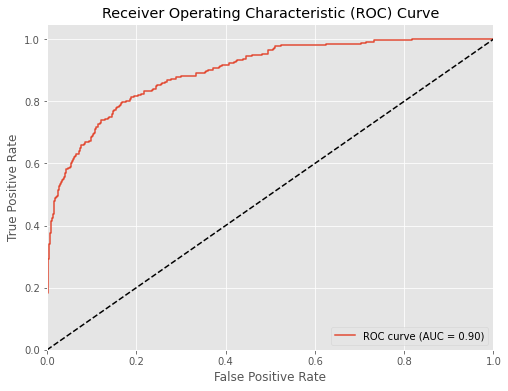

In [100]:
fpr, tpr, thresholds = roc_curve(target_test, predictions_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc_cat_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

We'll also take a look at the confusion matrix.

In [101]:
predictions = best_model_cat.predict(features_test)

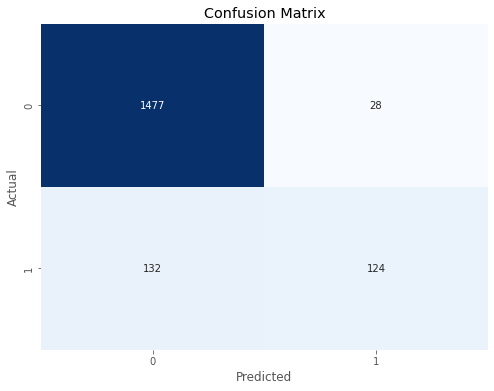

In [102]:
cm = confusion_matrix(target_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [103]:
true_negatives = cm[0, 0]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
true_positives = cm[1, 1]

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Precision: 0.82
Recall: 0.48


Precision of 0.82 means that out of all the customers the model predicted as churned, about 82% of them were actually churned customers.

Recall of 0.48 means that the model correctly identified about 48% of the actual churned customers

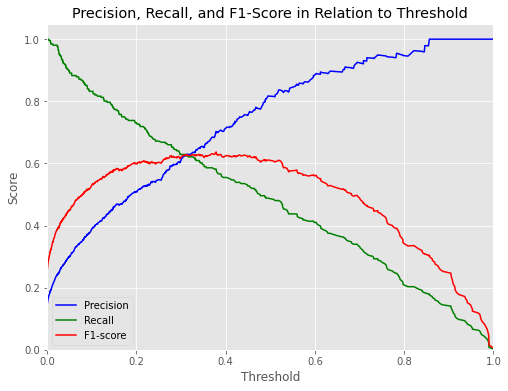

In [104]:
precision, recall, thresholds_pr = precision_recall_curve(target_test, predictions_proba)

f1_scores = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(8, 6))
plt.plot(thresholds_pr, precision[:-1], label='Precision', color='b')
plt.plot(thresholds_pr, recall[:-1], label='Recall', color='g')
plt.plot(thresholds_pr, f1_scores[:-1], label='F1-score', color='r')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score in Relation to Threshold')
plt.legend(loc='lower left')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

If we need Recall more than 0.48, say, 0.6, we could use threshold like 0.35, but precision will be 0.65.

And finally, let's take a look at feature importance.

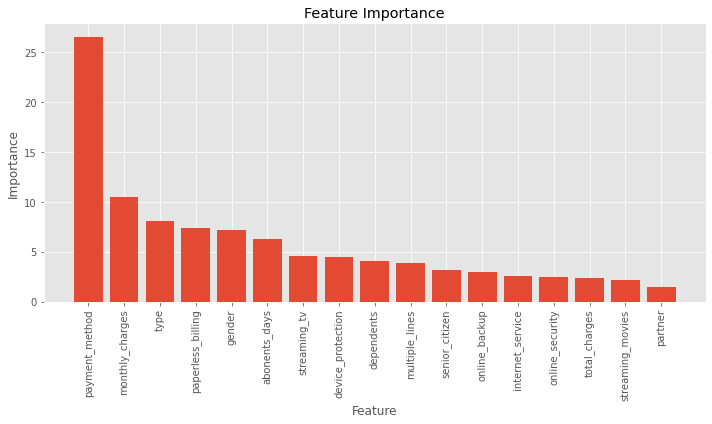

In [105]:
catboost_model = best_model_cat.named_steps['model_cat']
feature_importance = catboost_model.feature_importances_
feature_names = features_train.columns

sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), sorted_importance)
plt.xticks(range(len(sorted_importance)), sorted_names, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

Indeed, we can see that payment_method, monthly_charges, and type are the top 3 most important features. Surprisingly, customer lifetime is ranked 6th, even behind gender. Quite interesting!  
So, let's use permutation importance!

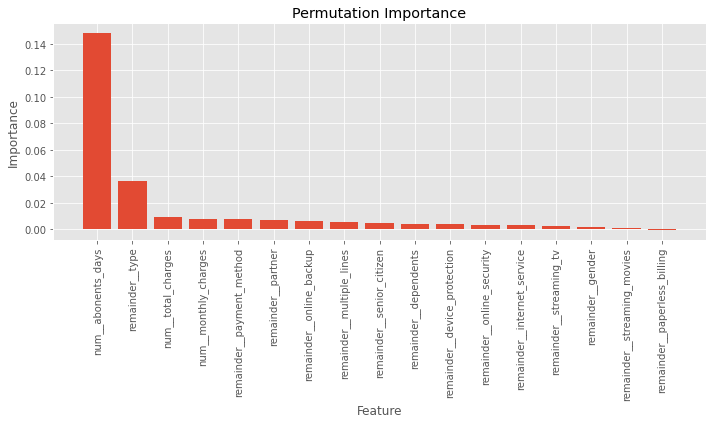

In [106]:
# Get the CatBoost model from the pipeline
catboost_model = best_model_cat.named_steps['model_cat']

# Transform the test features using the pipeline's preprocessor
features_test_transformed = best_model_cat.named_steps['preprocessor_cat'].transform(features_test)

# Calculate permutation importance
perm_importance = permutation_importance(catboost_model, features_test_transformed,\
                                         target_test, n_repeats=30, random_state=RANDOM_STATE)

# Get feature names
feature_names = best_model_cat.named_steps['preprocessor_cat'].get_feature_names_out\
(input_features=features_test.columns)

# Get sorted indices and importances
sorted_indices = np.argsort(perm_importance.importances_mean)[::-1]
sorted_importance = perm_importance.importances_mean[sorted_indices]
sorted_names = feature_names[sorted_indices]

# Visualize permutation importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), sorted_importance)
plt.xticks(range(len(sorted_importance)), sorted_names, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Importance')
plt.tight_layout()
plt.show()

Now we can see that our feature abonents_days is the main feature. There might have been some data leakage for the model, so it's advisable to use a time-based validation strategy or a time series cross-validation approach instead of the standard train_test_split.

And last step. Lets see shap importance.

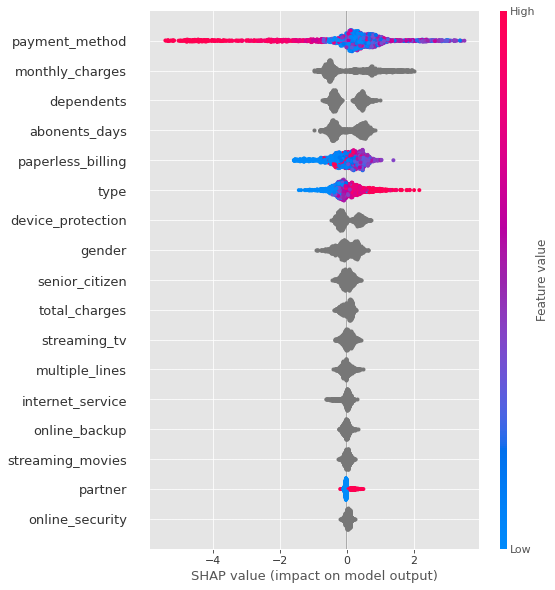

In [107]:
# Get the CatBoost model from the pipeline
catboost_model = best_model_cat.named_steps['model_cat']

# Transform the test features using the pipeline's preprocessor
features_test_transformed = best_model_cat.named_steps['preprocessor_cat'].transform(features_test)

# Create an explainer object using the TreeExplainer with feature_perturbation set to "tree_path_dependent"
explainer = shap.TreeExplainer(catboost_model, feature_perturbation="tree_path_dependent")

# Calculate SHAP values
shap_values = explainer.shap_values(features_test_transformed)

# Plot SHAP summary plot
shap.summary_plot(shap_values, features_test_transformed, feature_names=features_test.columns)

Interesting. We can see that the payment_method is again the most important feature. Moreover, the higher its value, the more negatively it affects the model's output.

## Conclusions:

1. All the steps of the plan were strictly followed, except perhaps for thorough anomaly exploration. However, upon inspecting the dataset, I concluded that there weren't too many anomalies to warrant spending time on them.

2. The project proceeded in four main steps: data preprocessing, data preparation for training, EDA, model training, and testing the best model on the test data.

3. I used all the original features except customer_id, tech_support and columns related to dates, namely: begin_date and end_date (combined into the feature abonents_days), type, paperless_billing, payment_method, monthly_charges, total_charges, gender, senior_citizen, partner, dependents, internet_service, online_security, online_backup, device_protection, streaming_tv, streaming_movies, and multiple_lines. 

    Regarding preprocessing, a crucial step was to ensure unique customer_ids in all four datasets, allowing for accurate merging without cross-duplicates. Another vital processing step involved standard scaling (which might not have been necessary for tree-based models, but neccessary for logistic regression), as well as One-Hot Encoding (OHE), which was essential for Decision Trees and Random Forests to learn.
4. The best final model turned out to be a CatBoost model with 500 iterations, tree depth of 8, and learning rate of 0.1. This model achieved a maximum ROC_AUC score of 0.87 on validation and 0.9 on the test data.

5. Best Precision and Recall is 0.82 and 0.48, but we can change it with changing threshold.